In [1]:
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import struct
from tqdm import tqdm

from typing import Union, Tuple, List

# some utility functions

def create_submission_file(fname,preds):
    """
    Create Kaggle submision with predictions written as a csv (comma separated values) file 
    """
    
    ofile  = open(fname, "w")
    writer = csv.writer(ofile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)    
    
    writer.writerow(['id', 'label'])
    
    
    for i in range(preds.shape[0]):
        writer.writerow([i,preds[i]])
        

def read_MNIST(dataset="training", path="./"):
    """
    Reads in the MNIST data
    This function allows specification of the part to be read (training/testing/validation)
    Note that if dataset='testing', no labels will be returned
    """
    
    #Figure out the name of the file to load    
    if dataset.lower() == "training":
        file_name_suffix = 'Tr'
        has_labels = True
    
    elif dataset.lower() == "validation":
        file_name_suffix = 'Vl'
        has_labels = True

    elif dataset.lower() == "testing":
        file_name_suffix = 'Te'
        has_labels = False

    else:
        print("dataset must be 'testing','validation', or 'training'")
        raise ValueError
    
    #Load the appropriate files
    X = np.load('./x'+file_name_suffix+'.npy')
    if has_labels:
        y = np.load('./y'+file_name_suffix+'.npy')
    
    X = np.float64(X).reshape(X.shape[0],-1)
    
    #Return the appropriate data
    if has_labels:
        return X,y
    else:
        return X


def show_MNIST_example(image):
    """
    Render a given numpy.uint8 array of pixel data as an image.
    """
    image = image[-28**2:]
    image = image.reshape(28,28)

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    plt.axis('off')
    plt.show()

Training image
Class: 5


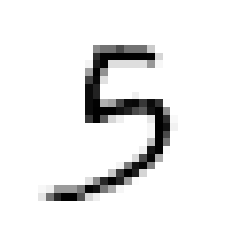

In [17]:
# load the data and visualize a training example
X,y = read_MNIST("training")
print("Training image")
print(f"Class: {y[10]}")
show_MNIST_example(X[10])

X_val,y_val = read_MNIST("validation")
X_test = read_MNIST("testing")



In [13]:
X.shape

(20000, 784)

In [18]:
# let's shuffle the data
np.random.seed(78912)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]


In [56]:
X.shape

(20000, 784)

In [21]:
class Node:
    """
    Building block of the Decision Tree.
    """
    left = None  # left child
    right = None  # right child
    index = None  # feature index (what is the feature by which we split)
    val = None  # what's the value at which we split
    # Once you arrive at a leaf Node then we use labels
    is_leaf = True
    label = None
    
    def __init__(self, left=None, right=None, index=None, val=None, is_leaf=True, label=None):
        self.left = left
        self.right = right
        self.val = val
        self.is_leaf = is_leaf
        self.label = label
        
    def classify(self, x):
        # this is a recursive function, following the path to the correct leaf
        if self.is_leaf:
            return self.label
        elif x[self.index] <= self.val:
            
            return self.left.classify(x)
        elif x[self.index] > self.val:
            
            return self.right.classify(x)
        
            
    def classify_set(self, X):
        # work on examples in a loop 
        res = []
        for sample in X:
            res.append(self.classify(sample))
        return np.asarray(res)
            
    #useful for debugging (on small trees)
    def print_tree(self) -> None:
        print(f"index = {self.index}, val = {self.val}, leaf = {self.is_leaf}, label = {self.label}, left = {self.left}, right = {self.right}")
        if self.left is not None:
            print("left = ", end="")
            self.left.print_tree()
        if self.right is not None:
            print("right = ", end="")
            self.right.print_tree()

In [22]:
# to classify a leaf node take the mode of the labels that arrive at the leaf
def label_leaf(labels):
    classes, counts = np.unique(labels, return_counts=True)
    return classes[np.argmax(counts)]

In [53]:
def best_split_gini(features, labels, min_split_size=5):
    """
    Given a set of feature values (for a single feature) and the corresponding labels,
    find the split that minimizes the (weighted by size) sum of the Gini indices of the two parts
    Note: the combined Gini index is given by len(L)*G[0]+len(U)*G[1]

    Returns: (tau, G, L, U)
        tau : the threshold to split
        G : 2-tuple with the Gini indices of the two parts
        L, U : indices of the points that go into L and U
    """
    
    # sort the feature values (and permute the labels to match that order)
    order = np.argsort(features)
    x = features[order]
    y = labels[order]
    N = len(x)

    classes = np.unique(labels)
    
    # check if there is nothing to split
    if (x[0]==x[-1]) or (len(classes)==1):
        return None, [np.inf,np.inf], range(N), None    
    
    # freq_u maintains frequencies of labels in the (potential) upper portion of the split,
    # and freq_l in the lower
    
    freq_u = np.zeros(np.max(classes) + 1)
    for c in range(len(freq_u)):
        freq_u[c] = np.mean(labels==c)
    freq_l = np.zeros(np.max(classes) + 1)
    
    # now go over the examples in order of increasing feature value;
    # consider splitting before each index where the value changes
    # rather that computing the Gini index from scratch for every split, we will keep track
    # of the running frequencies (as we traverse the list of examples ordered by feature value)
    # and simply recompute Gini from the frequencies each step (much faster)
    
    gini=dict()
    splits=dict()
    for i in range(N-1):
        # update frequencies
        freq_l[y[i]] += 1/N
        freq_u[y[i]] -= 1/N
        
        if x[i+1] > x[i]: # split here, between i and i+1?
            tau = (x[i+1] + x[i]) / 2.0
            
            gini_l = np.dot(freq_l, 1-freq_l)
            gini_u = np.dot(freq_u, 1-freq_u)
            
            gini[tau] = (i * gini_l + (N-i) * gini_u, gini_l, gini_u)
            splits[tau] = i+1 # index of the first element that goes to U

    # now find the best split
    best_tau = -1
    bestval = np.inf
    for t in gini:
        if gini[t][0] < bestval:
            best_tau = t
            bestval = gini[t][0]
    
    L = order[:splits[best_tau]]
    U = order[splits[best_tau]:]
    
    return best_tau, gini[best_tau][1:], L, U

In [24]:
def split_data(X, y, min_split_size=5, M=None):
    # Find the best way to split the data in X (with labels y) by a single feature
    # Don't split if not enough data given min_split_size (return None), otherwise
    # return a dictionary with the following key/value pairs:
    # 'd' -> the index of the feature in X by which we are splitting;
    # 'tau' -> the threshold at which we are splitting that feature;
    # 'Gini' -> the (weighted) Gini index of the two new leaves;
    # 'Gini-parts' -> a 2-tuple (list) of Gini indices of the L and U leaves after the split;
    # 'L' -> indices of the examples in X that go into the lower (left) leaf;
    # 'U' -> same for the upper (right) leaf
    #
    # M specifies the number of features to consider in looking for the best split. If M=None, this means using
    # all the features of X. Otherwise, if say M=50, this means pick 50 features at random and only consider 
    # splitting by these features.
    
    if X.shape[0] < min_split_size:
        return None
    if M != None:
        if M < X.shape[1]:
            feature_index = np.random.choice(X.shape[1],M,replace=False)
        else:
            feature_index = np.arange(X.shape[1])
    else:
        feature_index = np.arange(X.shape[1])
    
    info_dict = dict()
    info_dict['Gini'] = np.inf
    for d in feature_index:
        best_tau, _, L, U= best_split_gini(X[:,d], y, min_split_size)
        if best_tau == None:
            continue
        _,L_count = np.unique(y[L],return_counts=True)
        L_count = np.square(L_count/np.sum(L_count))
        Gini_parts=[]
        Gini_parts.append(1-np.sum(L_count))
        _,U_count = np.unique(y[U],return_counts=True)
        U_count = np.square(U_count/np.sum(U_count))
        Gini_parts.append(1-np.sum(U_count))
        Gini= (len(L)*Gini_parts[0] + len(U)*Gini_parts[1]) / (len(L)+len(U))
        if Gini < info_dict['Gini'] :
            info_dict['d'] = d
            info_dict['tau']=best_tau
            info_dict['Gini'] = Gini
            info_dict['Gini-parts'] = Gini_parts
            info_dict['L'] = L
            info_dict['U'] = U
    
    if info_dict['Gini'] == np.inf:
        return None
    return info_dict
    

In [25]:
def grow_tree(
    root, 
    data, 
    labels, 
    depth, 
    max_depth=np.inf, 
    min_split_size=1, 
    M=None):
    # this takes root (a node associated with data/labels, and existing at the given depth)
    # and builds a tree rooted at that node, not to exceed the given max_depth
   
    # take a look at Node.classify() to get a better sense how the recursive nature of the tree
    # lets you "drop a point down the tree" and assign a label once you are in the leaf
    
    if (depth == max_depth):
        no_split=True # we are done, no more splitting below this node
        
    else:
        
        best_split = split_data(data, labels, min_split_size,M)
        if best_split==None: # for some reason the splitting code refused to split
            
            no_split=True
        else: # splitting!
            
            no_split=False
            
            # COMPLETE CODE: assign values to .index, .val, .is_leaf
            root.index = best_split['d']
            root.val = best_split['tau']
            root.is_leaf = False

            root.left = grow_tree(Node(), data[best_split['L']], labels[best_split['L']], depth+1, max_depth,min_split_size,M)
            root.right = grow_tree(Node(), data[best_split['U']], labels[best_split['U']], depth+1, max_depth,min_split_size,M)
            
            
    if no_split: # this is going to be a leaf, let's record this fact and assign it a label to predict
        # COMPLETE CODE HERE  -- what do you need to assign in a leaf?

        root.is_leaf = True 
        root.label = label_leaf(labels)
    return root

In [26]:
def build_tree(data, labels, max_depth=np.inf, min_split_size=1, M=None):
    root=Node()
    tree=grow_tree(root,
                   data,
                   labels,
                   depth=0, # this will "signal" to the tree growing function that this is the root
                   max_depth=max_depth,
                   min_split_size=min_split_size,
                   M=M)
    return tree

In [84]:
tree = build_tree(X, y, max_depth=10, min_split_size=3, M=None) # may take a few minutes

In [67]:
tree.print_tree()

index = 568, val = 0.5, leaf = False, label = None, left = <__main__.Node object at 0x7f1d9d163a10>, right = <__main__.Node object at 0x7f1d9d0b2750>
left = index = 430, val = 6.5, leaf = False, label = None, left = <__main__.Node object at 0x7f1d9d163e90>, right = <__main__.Node object at 0x7f1d9d0b2a50>
left = index = 378, val = 149.5, leaf = False, label = None, left = <__main__.Node object at 0x7f1d9d163890>, right = <__main__.Node object at 0x7f1d9e01b590>
left = index = None, val = None, leaf = True, label = 7, left = None, right = None
right = index = None, val = None, leaf = True, label = 1, left = None, right = None
right = index = 542, val = 0.5, leaf = False, label = None, left = <__main__.Node object at 0x7f1d9d163f10>, right = <__main__.Node object at 0x7f1d9d390110>
left = index = None, val = None, leaf = True, label = 4, left = None, right = None
right = index = None, val = None, leaf = True, label = 6, left = None, right = None
right = index = 461, val = 14.5, leaf = Fa

### Computer training and validation accuracy for the tree

In [85]:
def accuracy(y_hat,y):
    """
    Compute accuracy (one minus average 0/1 loss) of model w relative to true labels y on data X
    """

    acc = np.sum(np.equal(y,y_hat).astype(np.float32))/y.shape[0]
    return acc

In [177]:
predict_y = tree.classify_set(X_val)

In [178]:
accuracy(predict_y,y_val)

0.8401

In [180]:
evaluate_ensemble([tree],X_val,y_val)

0.8401

In [181]:
preds = apply_ensemble([tree], X_test)
create_submission_file("decision_output", preds)

In order to prune the trees, the tree nodes need to store additional value. 
In this specific case, since it was pruned by misclassification rate.
The new node would store all the training labels that was assigned to this leaf nodes


In [148]:
class new_Node(Node):
    
    def __init__(self, left=None, right=None, index=None, val=None, is_leaf=True, label=None):
        super().__init__(left, right, index, val, is_leaf, label)
        self.training_label = np.array([])

In [165]:
def new_grow_tree(
    root, 
    data, 
    labels, 
    depth, 
    max_depth=np.inf, 
    min_split_size=1, 
    M=None):
    # this takes root (a node associated with data/labels, and existing at the given depth)
    # and builds a tree rooted at that node, not to exceed the given max_depth
   
    # take a look at Node.classify() to get a better sense how the recursive nature of the tree
    # lets you "drop a point down the tree" and assign a label once you are in the leaf
    
    if (depth == max_depth):
        no_split=True # we are done, no more splitting below this node
        
    else:
        
        best_split = split_data(data, labels, min_split_size,M)
        if best_split==None: # for some reason the splitting code refused to split
            
            no_split=True
        else: # splitting!
            
            no_split=False
            
            # COMPLETE CODE: assign values to .index, .val, .is_leaf
            root.index = best_split['d']
            root.val = best_split['tau']
            root.is_leaf = False

            root.left = new_grow_tree(Node(), data[best_split['L']], labels[best_split['L']], depth+1, max_depth,min_split_size,M)
            root.right = new_grow_tree(Node(), data[best_split['U']], labels[best_split['U']], depth+1, max_depth,min_split_size,M)
            
            
    if no_split: # this is going to be a leaf, let's record this fact and assign it a label to predict
        # COMPLETE CODE HERE  -- what do you need to assign in a leaf?

        root.is_leaf = True 
        root.label = label_leaf(labels)
        root.training_label = labels
    return root

In [158]:
def new_build_tree(data, labels, max_depth=np.inf, min_split_size=1, M=None):
    root=new_Node()
    tree=new_grow_tree(root,
                   data,
                   labels,
                   depth=0, # this will "signal" to the tree growing function that this is the root
                   max_depth=max_depth,
                   min_split_size=min_split_size,
                   M=M)
    return tree

In [166]:
new_tree = new_build_tree(X, y, max_depth=10, min_split_size=3, M=None) # may take a few minutes

In [155]:
def leaf_misclassify_rate(root):
    if root.is_leaf:
        return np.sum(root.training_label != root.label)
        

In [168]:
def pruning(root,lamda = 5):
    
    if not root.left.is_leaf:
        pruning(root.left, lamda)
    if not root.right.is_leaf:
        pruning(root.right, lamda)

    if root.left.is_leaf and root.right.is_leaf:
        mis_l = leaf_misclassify_rate(root.left)
        mis_r = leaf_misclassify_rate(root.right)
        new_training_label = np.hstack([root.left.training_label,root.right.training_label])
        new_label = label_leaf(new_training_label)
        mis_new =np.sum(new_training_label != new_label)
        if mis_new - mis_l - mis_r < lamda: # increased misclassification rate is less than reduced of
                                                    #one lambda because every pruning reduce one leaf.
            root.is_leaf = True 
            root.label = new_label
            root.training_label = new_training_label
        return  


In [169]:
pruning(new_tree)

In [170]:
predict_y_p = new_tree.classify_set(X_val)
accuracy(predict_y_p,y_val)

0.8387

In [54]:
test_tree = build_tree(X, y, max_depth=3, min_split_size=3, M=None) # may take a few minutes

inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best sp

inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best split gini
20000
inside best sp

KeyboardInterrupt: 

In [30]:
evaluate_ensemble([test_tree],X_val,y_val)

0.4983

## Bagging Section

In [31]:
# Helper functions for running bagging ensembles on data
def apply_ensemble(trees, data, C=10):
    """Returns the labels after applying the ensemble"""
    res = np.array([tree.classify_set(data) for tree in trees])
    yhat = np.zeros(res.shape[1])
    for i in range(res.shape[1]):
        yhat[i]=np.argmax(np.bincount(res[:,i]))
    return yhat.astype(int)

def evaluate_ensemble(trees, data, labels):
    """Returns the accuracy of the ensemble"""
    return np.mean(apply_ensemble(trees, data) == labels)

In [49]:
# Bagging
def create_ensemble(X, y, max_depth=10, min_split_size=1, num_trees=5, M_fraction=0.5):
    """
    M_fraction gives M as a fraction of d (# of features in X)
    """
    N, d = X.shape
    assert 0 < M_fraction < 1.0
    M = int(d*M_fraction)  # compute the actual M (number of features to consider in each node)
    
    trees = []
    for _ in tqdm(range(num_trees)): # this will show progress bar as you build the forest
        
        # COMPLETE CODE HERE -- construct tree
#         indices = np.arange(X.shape[0])
#         np.random.shuffle(indices)
#         X = X[indices]
#         y = y[indices]
        x_index = np.random.choice(N,N)
        #x_index = np.arange(int(N/2))
        print(np.shape(np.unique(x_index)))
        #x_index = np.arange(np.shape(np.unique(x_index))[0])
        tree_e=build_tree(X[np.unique(x_index)], y, max_depth, min_split_size, M)
        
        trees.append(tree_e)
        
    return trees

In [50]:
ensemble = create_ensemble(X, y, max_depth=10, min_split_size=3, num_trees=10, M_fraction=0.5)

  0%|          | 0/10 [00:00<?, ?it/s]

(12618,)


 10%|█         | 1/10 [01:33<13:58, 93.12s/it]

(12599,)


 20%|██        | 2/10 [02:54<11:57, 89.74s/it]

(12639,)


 30%|███       | 3/10 [04:14<10:07, 86.74s/it]

(12578,)


 40%|████      | 4/10 [05:41<08:40, 86.70s/it]

(12694,)


 50%|█████     | 5/10 [07:27<07:42, 92.45s/it]

(12620,)


 60%|██████    | 6/10 [09:06<06:18, 94.53s/it]

(12582,)


 70%|███████   | 7/10 [10:41<04:43, 94.64s/it]

(12593,)


 80%|████████  | 8/10 [12:11<03:06, 93.29s/it]

(12574,)


 90%|█████████ | 9/10 [13:53<01:35, 95.72s/it]

(12662,)


100%|██████████| 10/10 [15:23<00:00, 92.37s/it]


### Compute train/val accuracy of the ensemble

In [51]:
evaluate_ensemble(ensemble, X_val, y_val)

0.1548

### Plot the val accuracy as a function of ensemble size

In [152]:
acc = np.array([evaluate_ensemble(ensemble[:i], X_val, y_val) for i in range(1,len(ensemble)+1)])

In [153]:
acc.shape

(50,)

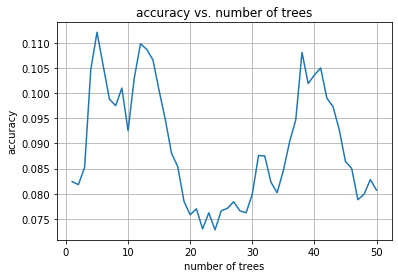

In [154]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(1,51)

fig, ax = plt.subplots()
ax.plot(t, acc)

ax.set(xlabel='number of trees', ylabel='accuracy',
       title='accuracy vs. number of trees')
ax.grid()

plt.show()

0.1028

In [ ]:
preds = apply_ensemble(ensemble, X_test)
create_submission_file("output", preds)